<a href="https://colab.research.google.com/github/nadiasuweer4ya/Breast_Cancer_Ultrasound_Image_Segmentation_Using_U-Net/blob/main/Brain_Tumor_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install imageio==2.27.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.1
    Uninstalling imageio-2.31.1:
      Successfully uninstalled imageio-2.31.1


In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

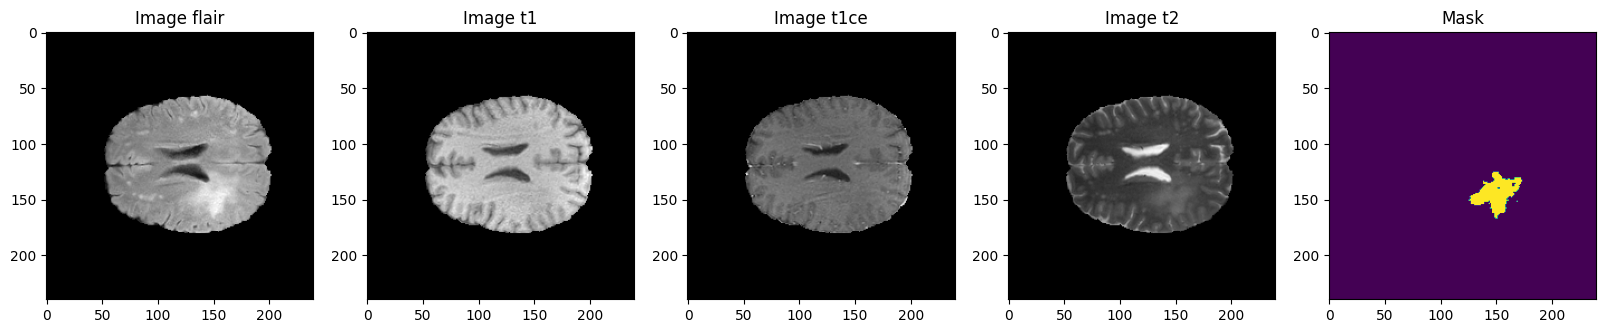

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

TRAIN_DATASET_PATH = '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/Dataset20/BraTS2020_ValidationData'

# Construct the file paths using os.path.join
flair_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_003', 'BraTS20_Training_003_flair.nii')
t1_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_003', 'BraTS20_Training_003_t1.nii')
t1ce_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_003', 'BraTS20_Training_003_t1ce.nii')
t2_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_003', 'BraTS20_Training_003_t2.nii')
mask_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_003', 'BraTS20_Training_003_seg.nii')

# Load the image data
test_image_flair = nib.load(flair_path).get_fdata()
test_image_t1 = nib.load(t1_path).get_fdata()
test_image_t1ce = nib.load(t1ce_path).get_fdata()
test_image_t2 = nib.load(t2_path).get_fdata()
test_mask = nib.load(mask_path).get_fdata()

# Visualize the image data using matplotlib
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:, :, test_image_flair.shape[0] // 2 - slice_w], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:, :, test_image_t1.shape[0] // 2 - slice_w], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[0] // 2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:, :, test_image_t2.shape[0] // 2 - slice_w], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:, :, test_mask.shape[0] // 2 - slice_w])
ax5.set_title('Mask')

plt.show()


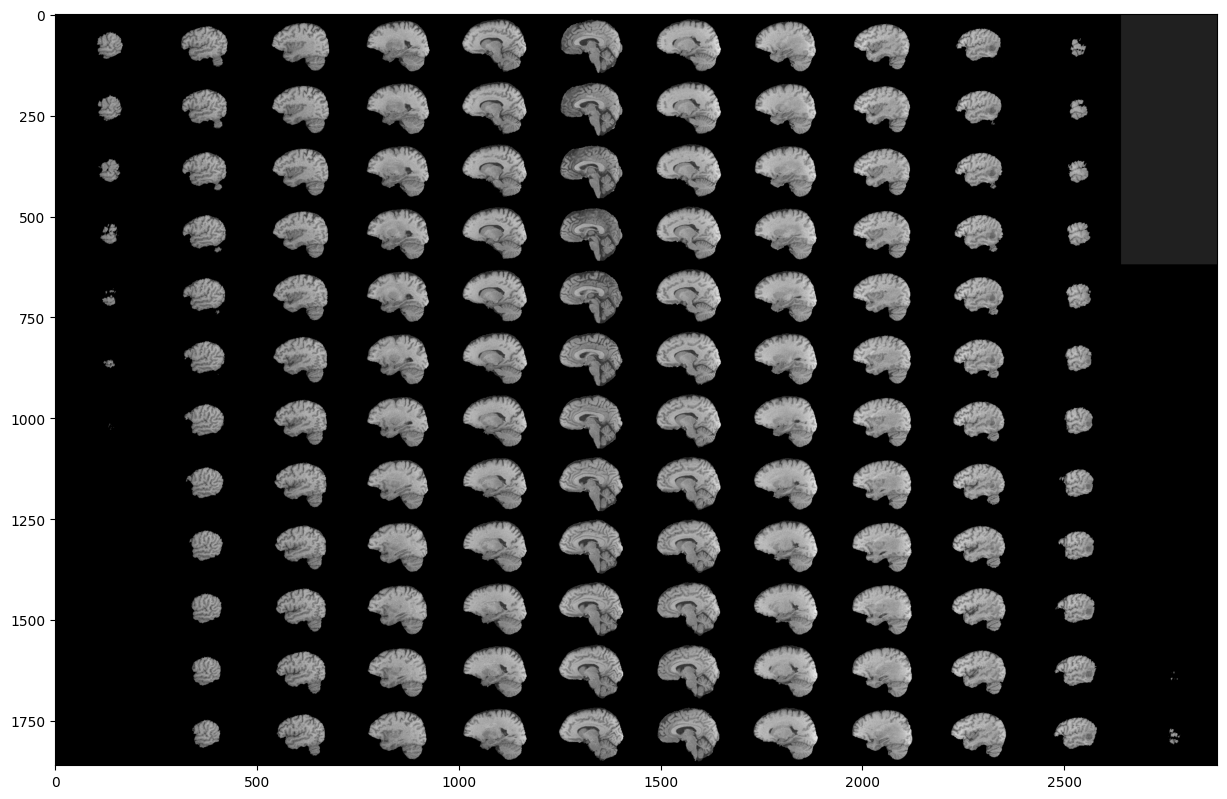

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

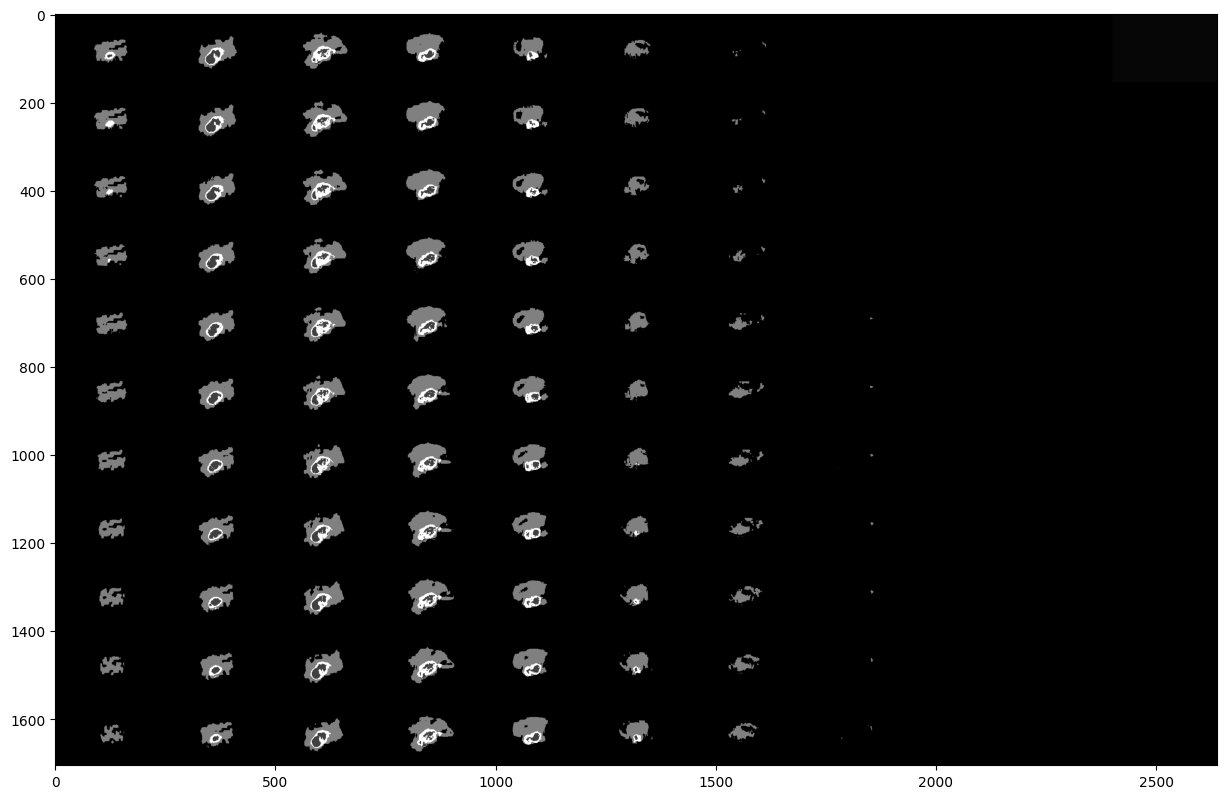

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

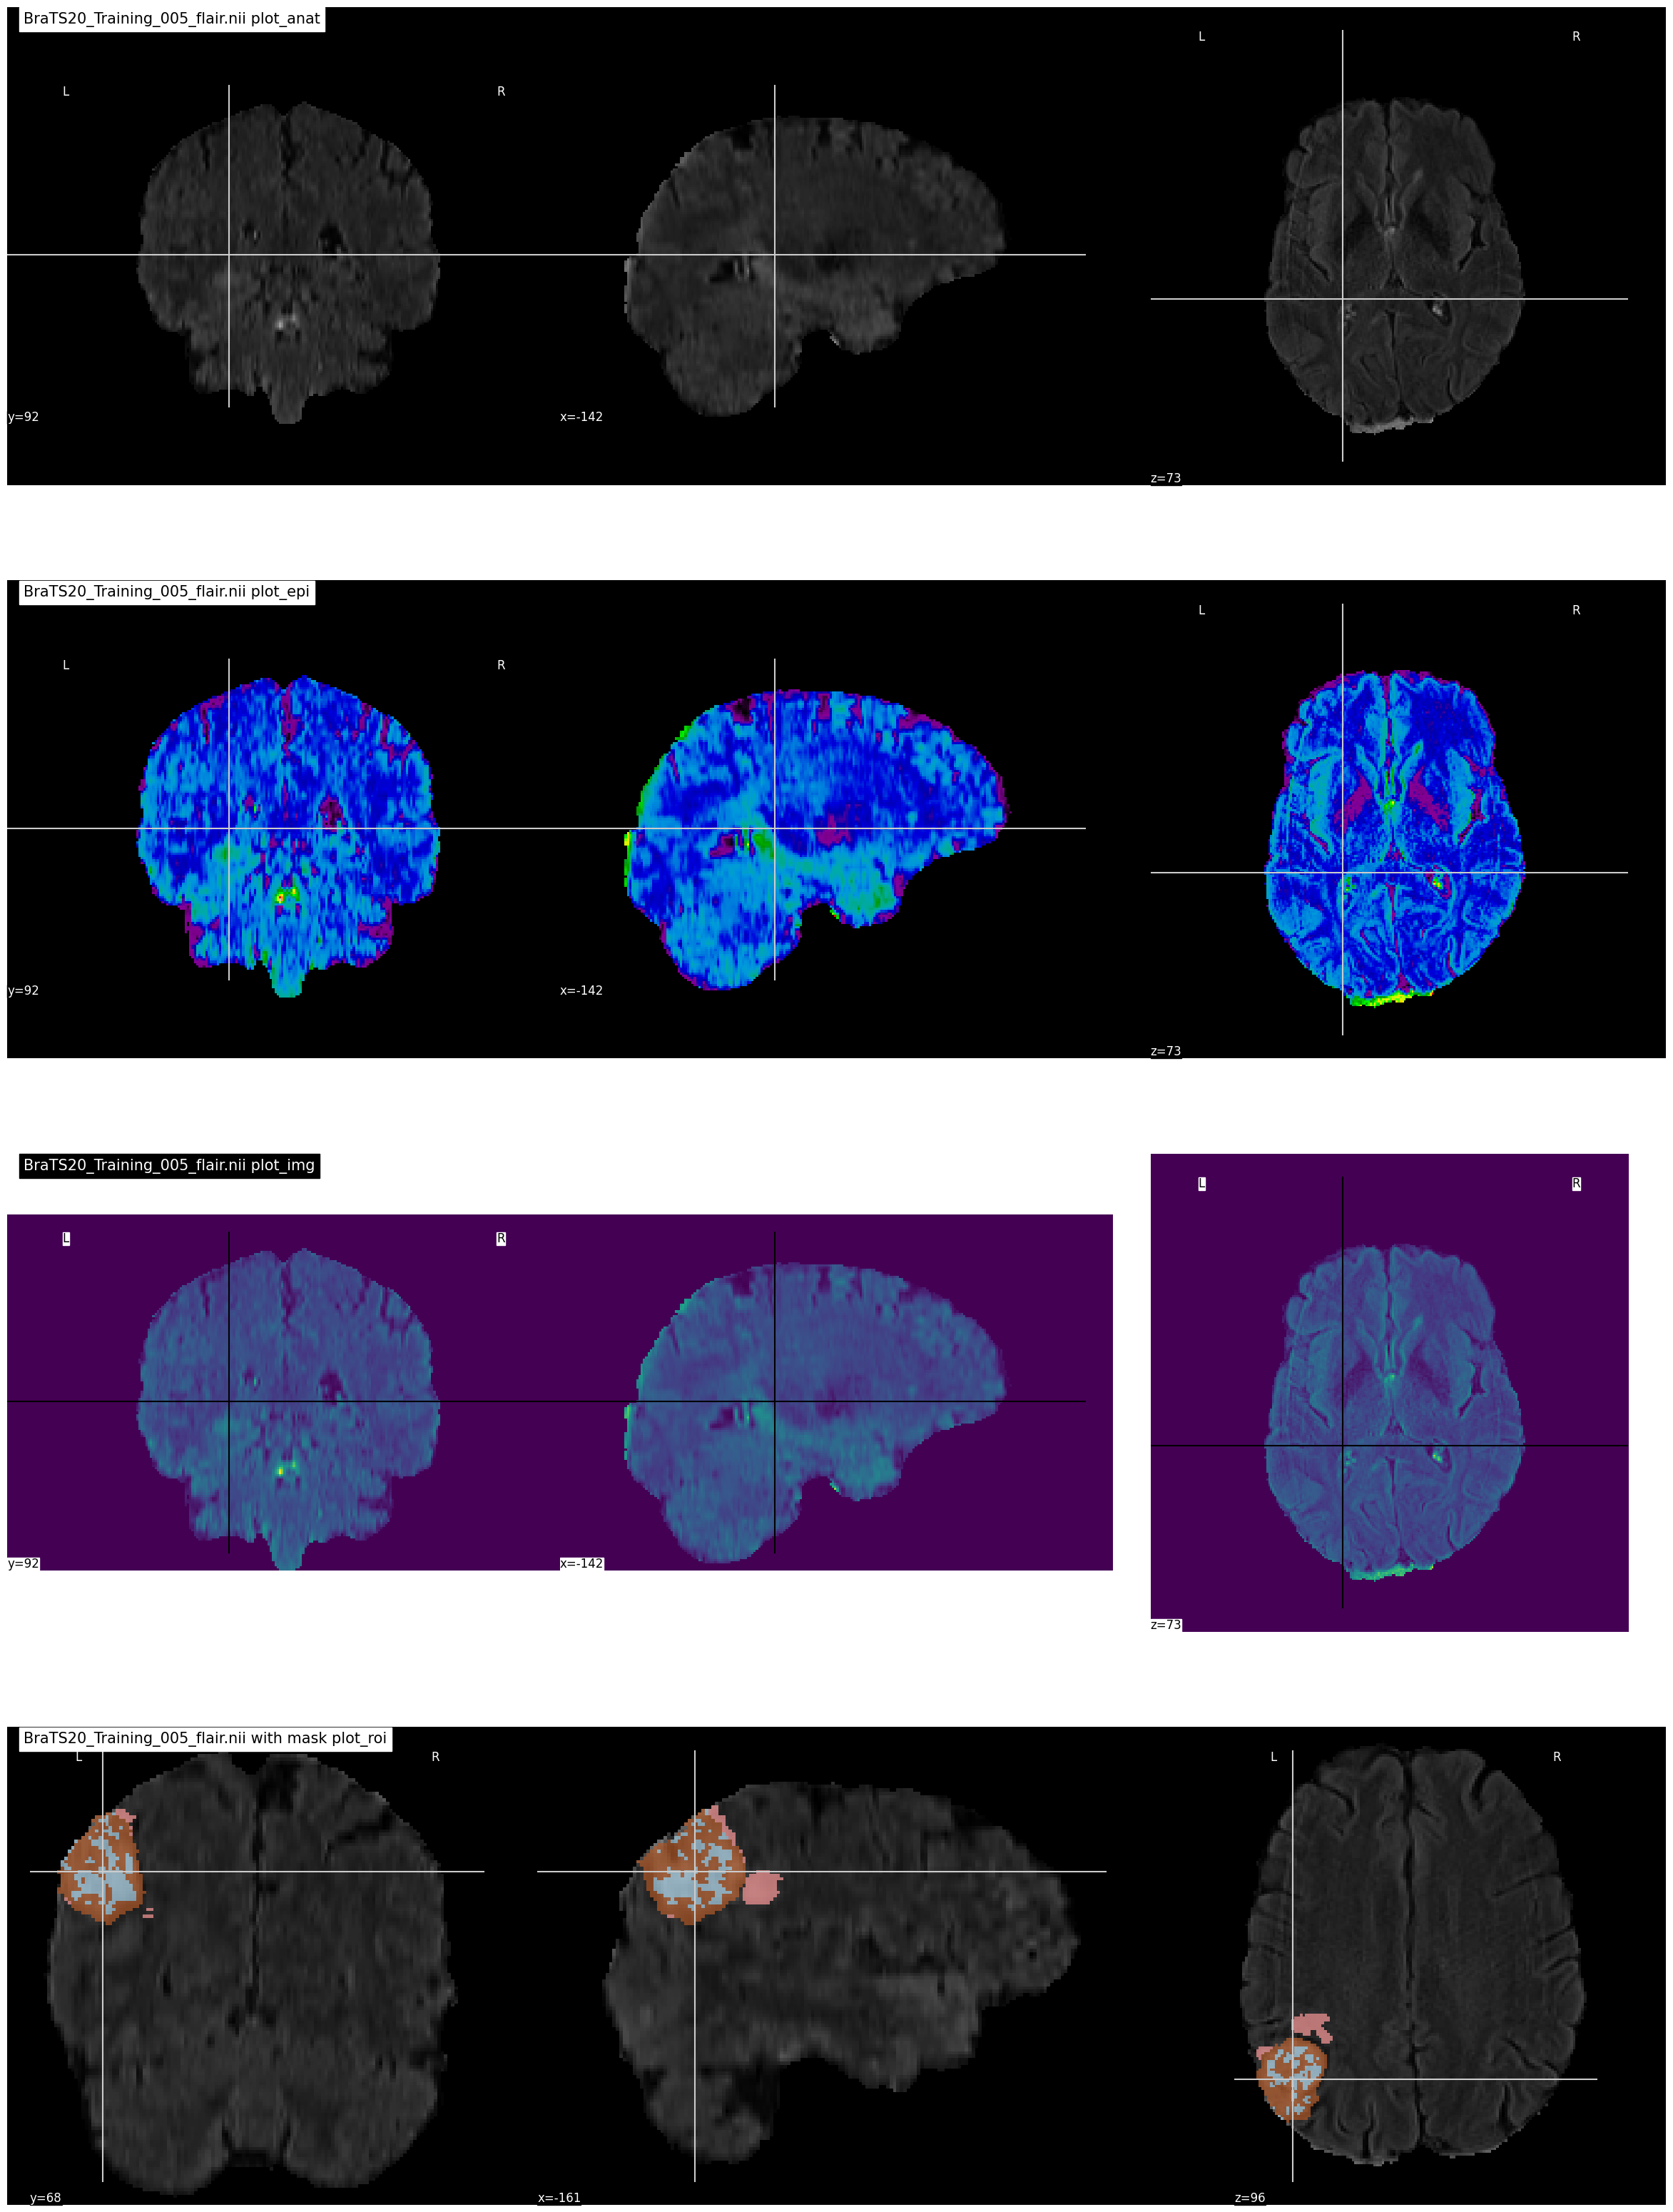

In [ ]:
import os
import nilearn as nl
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt

TRAIN_DATASET_PATH = '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData'

# Define the paths to the NIfTI files
niimg_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_005', 'BraTS20_Training_005_flair.nii')
nimask_path = os.path.join(TRAIN_DATASET_PATH, 'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_005', 'BraTS20_Training_005_seg.nii')

# Load the NIfTI images using Nilearn
niimg = nl.image.load_img(niimg_path)
nimask = nl.image.load_img(nimask_path)

# Create subplots for the different visualizations
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

# Plot anatomical image
nlplt.plot_anat(niimg,
                title='BraTS20_Training_005_flair.nii plot_anat',
                axes=axes[0])

# Plot EPI image
nlplt.plot_epi(niimg,
               title='BraTS20_Training_005_flair.nii plot_epi',
               axes=axes[1])

# Plot image
nlplt.plot_img(niimg,
               title='BraTS20_Training_005_flair.nii plot_img',
               axes=axes[2])

# Plot ROI with mask
nlplt.plot_roi(nimask,
               title='BraTS20_Training_005_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

# Display the plots
plt.show()


In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

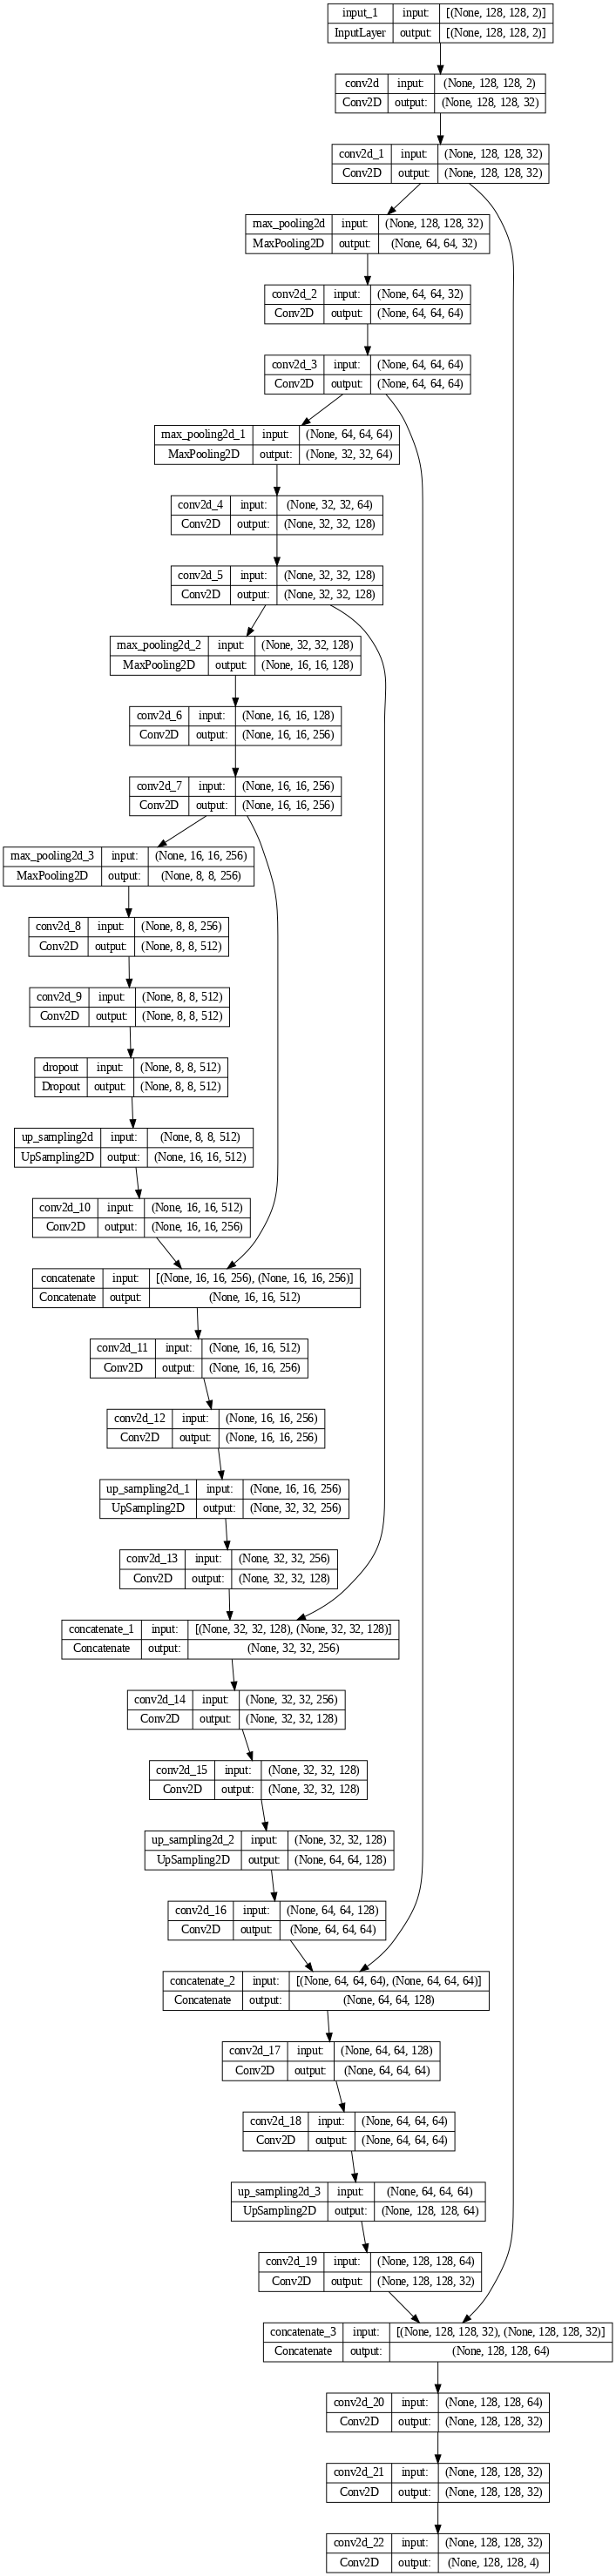

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset20'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_flair.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_t1ce.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_seg.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_t1.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_t2.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii
/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii
/content/drive/MyDrive/Dataset20/BraTS2020_Tr

In [ ]:
Flair= nib.load('/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_flair.nii')
Seg= nib.load('/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii')
T1= nib.load('/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t1.nii')
T1ce= nib.load('/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t1ce.nii')
T2= nib.load('/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t2.nii')

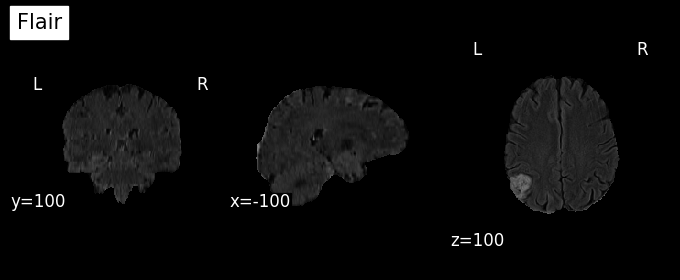

In [ ]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

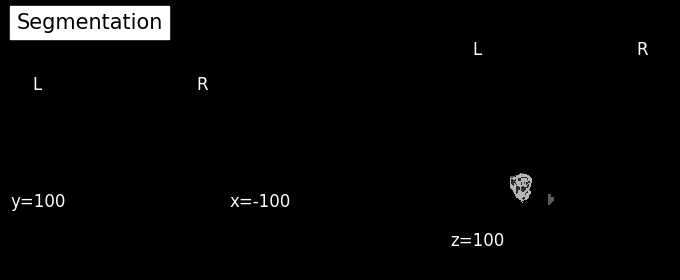

In [ ]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Segmentation",draw_cross =False)

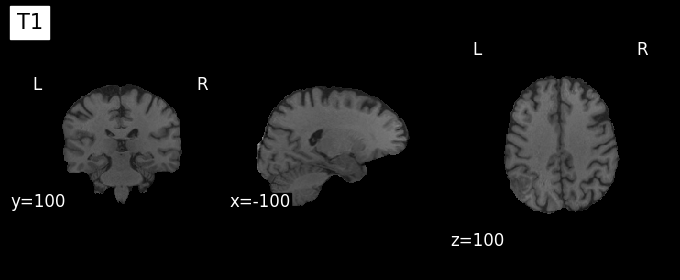

In [ ]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

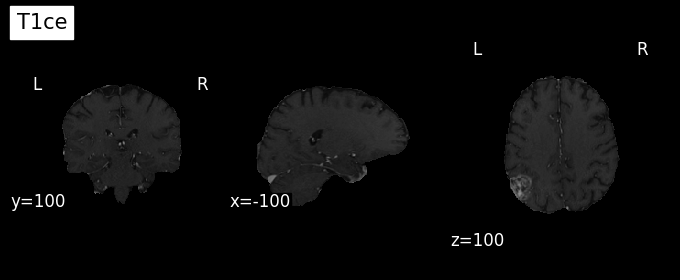

In [ ]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

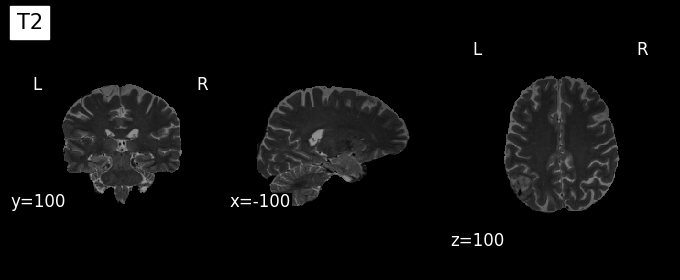

In [ ]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

In [ ]:
Path= '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []
    for modality in modalities_dir:
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_flair.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t1.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t1ce.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t2.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '/content/drive/MyDrive/Dataset20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)

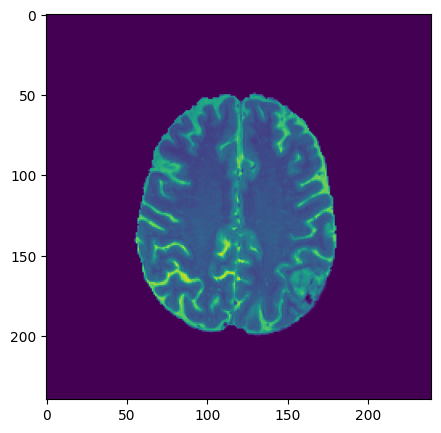

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[1][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
InData= Data_Concatenate(Input_Data)

$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)


In [ ]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0

In [ ]:
def Convolution(input_tensor,filters):

    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def model(input_shape):

    inputs = Input((input_shape))

    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)

    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)

    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)

    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)

    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)

    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)

    upsample_7 = concatenate([upsample_7, conv_3])

    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)

    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)

    upsample_9 = concatenate([upsample_9, conv_1])

    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
# Loding the Light weighted CNN
model = model(input_shape = (240,240,1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 240, 240, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 32  128        ['conv2d_23[0][0]']              
 alization)                     )                                                           

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Compiling the model
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=40,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/40
47/47 [==============================] - 46s 464ms/step - loss: 0.4387 - accuracy: 0.9181 - dice_coef: 0.0230 - precision: 0.1882 - sensitivity: 0.8660 - specificity: 0.9214 - val_loss: 0.3183 - val_accuracy: 0.9835 - val_dice_coef: 0.0263 - val_precision: 0.1378 - val_sensitivity: 0.7183 - val_specificity: 0.9860
Epoch 2/40
47/47 [==============================] - 17s 367ms/step - loss: 0.1882 - accuracy: 0.9936 - dice_coef: 0.0484 - precision: 0.4361 - sensitivity: 0.8550 - specificity: 0.9948 - val_loss: 0.4645 - val_accuracy: 0.8596 - val_dice_coef: 0.0130 - val_precision: 0.0078 - val_sensitivity: 0.3751 - val_specificity: 0.8617
Epoch 3/40
47/47 [==============================] - 17s 366ms/step - loss: 0.1185 - accuracy: 0.9939 - dice_coef: 0.0806 - precision: 0.4306 - sensitivity: 0.8796 - specificity: 0.9958 - val_loss: 0.2362 - val_accuracy: 0.9917 - val_dice_coef: 0.0527 - val_precision: 0.2757 - val_sensitivity: 0.7653 - val_specificity: 0.9941
Epoch 4/40
47/47 [=

In [ ]:
# Evaluating the model on the training and testing data
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

11/11 [==============================] - 2s 204ms/step - loss: -0.0606 - accuracy: 0.9977 - dice_coef: 1.3001 - precision: 0.8931 - sensitivity: 0.9971 - specificity: 0.9997


[-0.0605623684823513,
 0.9977299571037292,
 1.3001004457473755,
 0.8931121230125427,
 0.9970962405204773,
 0.9997174739837646]

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

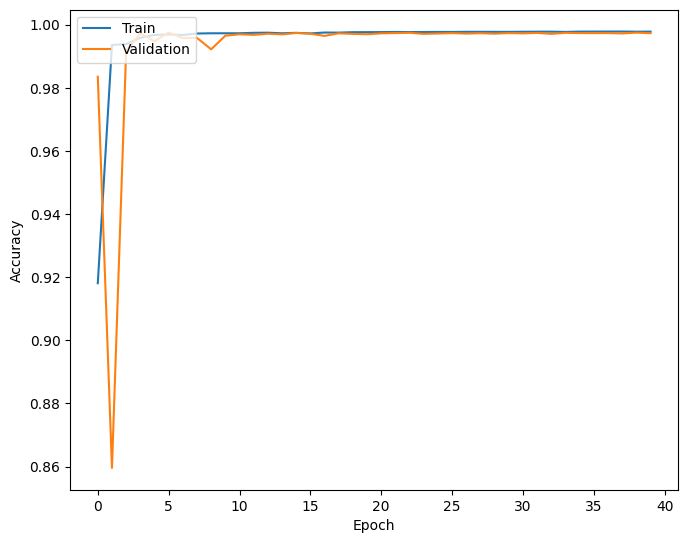

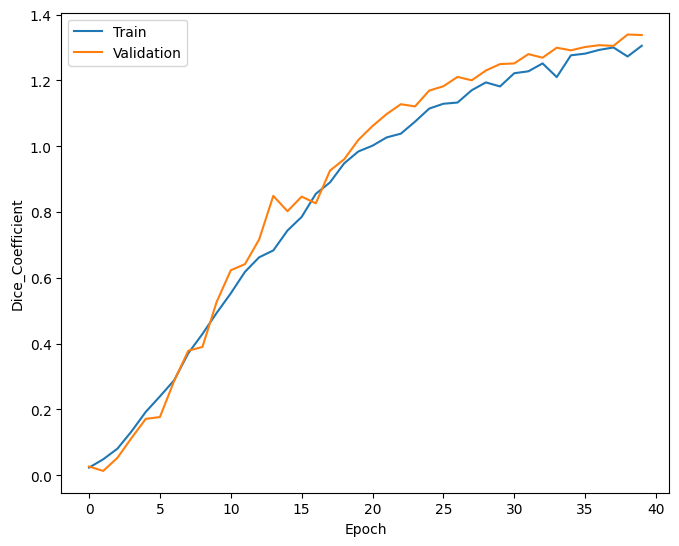

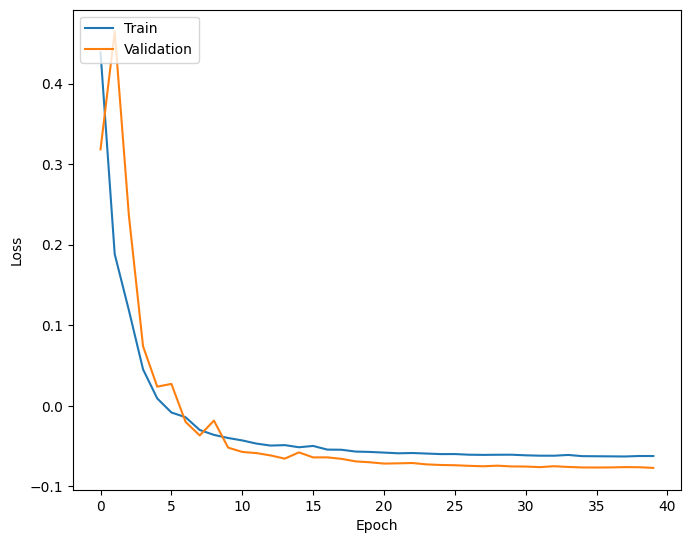

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

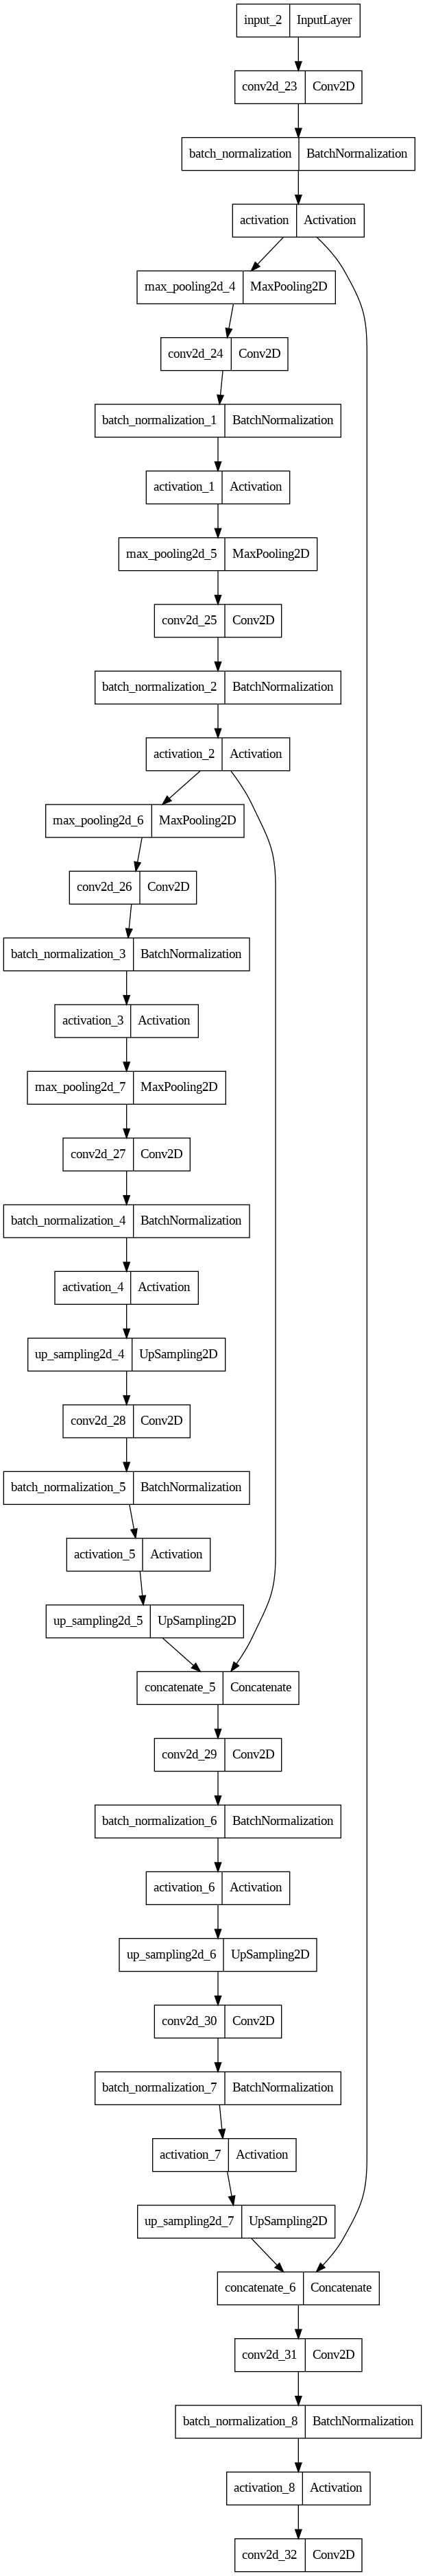

In [ ]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
model.save('./BraTs2020.h5')

In [ ]:
model.load_weights('./BraTs2020.h5')

In [ ]:
X_train=X_test=Y_train=Y_test=0

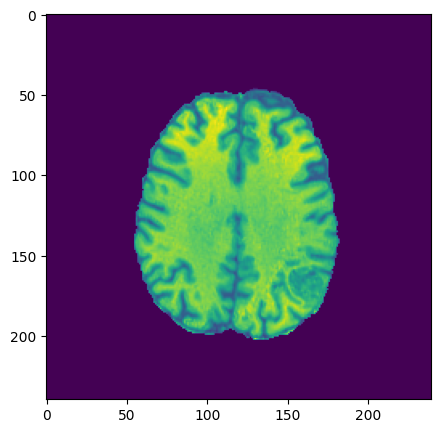

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [ ]:
pref_Tumor = model.predict(TR)

68/68 [==============================] - 11s 152ms/step


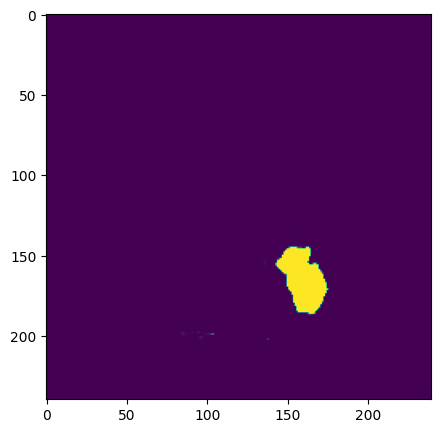

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

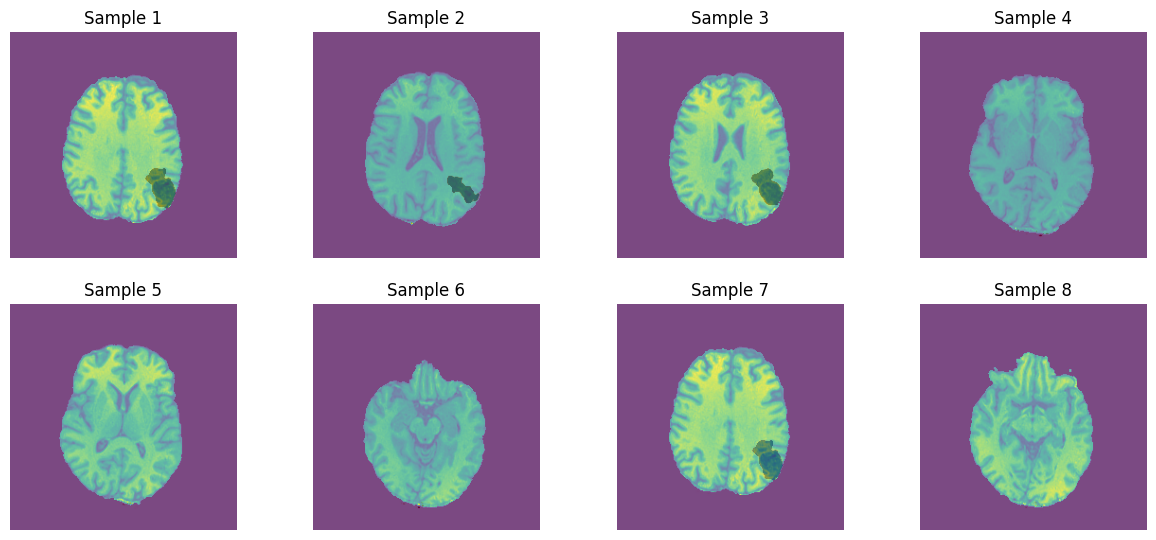

In [ ]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]))
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]))
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]))
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]))
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]))
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]))
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]))
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='RdPu')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]))
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='RdPu')